In [4]:
import numpy as np
import matplotlib.pyplot as plt
from foraging_environment import ForagingEnvironment

## Initialize the environment

In [5]:
env = ForagingEnvironment()
env_info = {"time_step_duration": 0.1, "session_duration_min": 6, "seed": 42}
env.env_init(env_info)
print("--- Start Environment Testing ---")

--- Start Environment Testing ---


## Test 1: Single Trajectory "Smoke Test"


--- Running Test 1: Single Trajectory Smoke Test ---


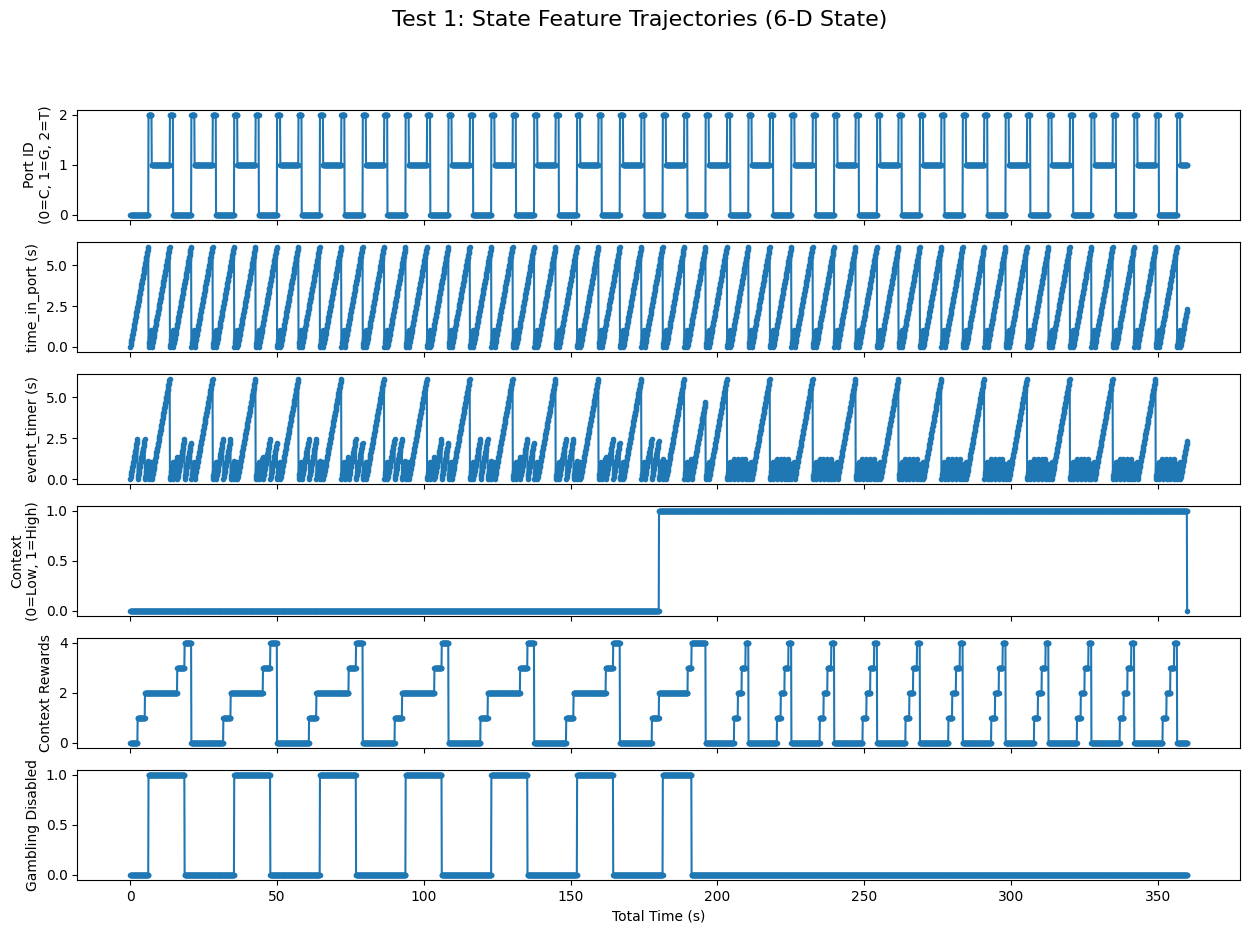

In [6]:
print("\n--- Running Test 1: Single Trajectory Smoke Test ---")
observation = env.env_start()
states = [observation]
total_reward = 0
is_terminal = False

# simple dummy policy: stay for 15 sec in any port then leave
LEAVE_TIME = 6

while not is_terminal:
    port_id, time_in_port, event_timer, context, rewards, disabled = observation

    action = 0 # Default to stay
    if port_id == env.CONTEXT_PORT and time_in_port > LEAVE_TIME:
        action = 1 # Leave after finishing context
    elif port_id == env.GAMBLING_PORT and time_in_port > LEAVE_TIME:
        action = 1 # Leave gambling after 15s

    reward, observation, is_terminal = env.env_step(action)
    states.append(observation)

states = np.array(states)

# Plot the state features over time
fig, axes = plt.subplots(6, 1, figsize=(15, 10), sharex=True)
time_points = np.arange(states.shape[0]) * env.dt

axes[0].plot(time_points, states[:, 0], '.-')
axes[0].set_ylabel("Port ID\n(0=C, 1=G, 2=T)")
axes[1].plot(time_points, states[:, 1], '.-')
axes[1].set_ylabel("time_in_port (s)")
axes[2].plot(time_points, states[:, 2], '.-')
axes[2].set_ylabel("event_timer (s)")
axes[3].plot(time_points, states[:, 3], '.-')
axes[3].set_ylabel("Context\n(0=Low, 1=High)")
axes[4].plot(time_points, states[:, 4], '.-')
axes[4].set_ylabel("Context Rewards")
axes[5].plot(time_points, states[:, 5], '.-')
axes[5].set_ylabel("Gambling Disabled")
axes[5].set_xlabel("Total Time (s)")
fig.suptitle("Test 1: State Feature Trajectories (6-D State)", fontsize=16)
plt.show()

## Test 2: Context Port Validation

### 2a: Staying in the context port delivers exactly 4 rewards at the correct times and then stops

In [8]:
print("\n--- Running Test 2: Context Port Validation ---")
observation = env.env_start()
is_terminal = False
reward_times = []

while not is_terminal and observation[0] == env.CONTEXT_PORT:
    reward, observation, is_terminal = env.env_step(0) # Always stay
    if reward > 0:
        reward_times.append(observation[1])

print(f"Context: {'High' if observation[2] == 1 else 'Low'}")
print(f"Received {len(reward_times)} rewards in the Context Port.")
print(f"Reward times (s): {[round(t, 2) for t in reward_times]}")

# Rigorous check
assert len(reward_times) == 4, "TEST FAILED: Did not receive 4 rewards!"
interval = env.high_rate_interval if observation[2] == 1 else env.low_rate_interval
expected_times = [(i + 1) * interval for i in range(4)]
assert np.allclose(reward_times, expected_times, atol=env.dt), "TEST FAILED: Reward timing is incorrect!"

print("--- Test 2 Passed! ---")


--- Running Test 2: Context Port Validation ---
Context: Low
Received 4 rewards in the Context Port.
Reward times (s): [np.float64(2.5), np.float64(5.0), np.float64(7.5), np.float64(10.0)]
--- Test 2 Passed! ---


### 2b: Validate the "resume" logic for the context port

In [9]:
print("\n--- Running Test 2b: Premature Leave & Resume Logic ---")
env.env_init(env_info) # Re-initialize
observation = env.env_start()
is_terminal = False
reward_times = []
time_of_leave = -1
time_of_return = -1

# Dummy policy: Wait for 1st reward, wait 1s more, then leave.
while not is_terminal:
    port_id, time_in_port, event_timer, _, rewards, disabled = observation
    action = 0 # Default to stay

    # If in context port...
    if port_id == env.CONTEXT_PORT:
        # After getting 1st reward and waiting 1 more second, leave.
        if rewards == 1 and time_of_leave < 0 and event_timer >= 1.0:
            action = 1
            time_of_leave = env.total_time_elapsed
            print(f"Leaving context port at {time_of_leave:.2f}s with {rewards} reward.")
        # If we have left and come back, just stay until the session ends
        elif rewards >= 2:
            break

    # If in gambling port (after leaving context), leave immediately to go back
    elif port_id == env.GAMBLING_PORT:
        action = 1

    # If traveling back to context port
    if is_terminal: break
    reward, observation, is_terminal = env.env_step(action)
    if reward > 0:
        reward_times.append(env.total_time_elapsed)

    if time_of_leave > 0 and time_of_return < 0 and observation[0] == env.CONTEXT_PORT:
        time_of_return = env.total_time_elapsed
        print(f"Returned to context port at {time_of_return:.2f}s.")

print(f"\nReward times: {[round(t, 2) for t in reward_times]}")
first_reward_time = reward_times[0]
second_reward_time = reward_times[1]
wait_time_after_return = second_reward_time - time_of_return

interval = env.low_rate_interval if observation[3] == 0 else env.high_rate_interval
expected_wait_time = interval - 1.0 # 2.5 (or 1.25) interval minus the 1.0s we waited before leaving

print(f"Waited {wait_time_after_return:.2f}s for 2nd reward after returning.")
print(f"Expected wait time was {expected_wait_time:.2f}s.")

assert np.isclose(wait_time_after_return, expected_wait_time, atol=env.dt), "TEST FAILED: Resume logic is incorrect!"
print("--- Test 2b Passed! ---")


--- Running Test 2b: Premature Leave & Resume Logic ---
Leaving context port at 3.60s with 1.0 reward.
Returned to context port at 6.00s.

Reward times: [2.5, 7.4]
Waited 1.40s for 2nd reward after returning.
Expected wait time was 1.50s.
--- Test 2b Passed! ---
